In [ ]:
# WL
# 多个文件夹
from datetime import datetime
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from utils.tools import make_dir

from utils.tools import calMeans, plot_func
    

WL_list = []

# 自定义排序函数：提取倒数第二个数字
def sort_key(folder_name):
    # 假设文件夹名称格式为 MJ_PCA_1_256，提取倒数第二个数字
    parts = folder_name.split('_')  # 按下划线分割
    if len(parts) >= 2 and parts[-2].isdigit():  # 确保倒数第二个部分是数字
        WL_list.append(int(parts[-1]))
        return int(parts[-1])  # 返回倒数第二个数字作为排序键
    else:
        return float('inf')  # 如果不符合格式，放在最后

formatted_time = datetime.now().strftime("%m-%d-%H:%M:%S")
saveFolderName = "WL——指标对比"
save_Dir = os.path.join('/home/admin123/SATData/Run', "figures", saveFolderName)
make_dir(save_Dir)

parent_folderL = ['/home/admin123/SATData/Run/WL_evaluation']
sorted_subfolderL = []
for parent_folder in parent_folderL:
    subfolders = [name for name in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, name))]
# 对子文件夹进行排序
    sorted_subfolders = sorted(subfolders, key=sort_key)
    sorted_subfolderL.append(sorted_subfolders)


mean_rmseL = []
mean_maeL = []
mean_r2L = []
WL_list = sorted(set(WL_list))
print("delta_Tlist: ", WL_list)

for i in range(len(sorted_subfolderL[0])):
    rmseL = []
    maeL = []
    r2L = []
    for j in range(len(sorted_subfolderL)):
        file_path = os.path.join(parent_folder, sorted_subfolderL[j][i], "metrics.json")
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)  # 将 JSON 数据加载为 Python 对象
            rmseL.append(np.array(data['rmse']))
            maeL.append(np.array(data['mae']))
            r2L.append(np.array(data['r2']))
    rmse = np.vstack(rmseL)
    mae = np.vstack(maeL)
    r2 = np.vstack(r2L)
    rmse_m, mae_m, r2_m = calMeans(rmse, mae, r2, allFlag=False)
    mean_rmseL.append(rmse_m)
    mean_maeL.append(mae_m)
    mean_r2L.append(r2_m)
    # print(rmse)


xleft = 0
xright = 40

mean_maeL = np.array(mean_maeL)
mean_rmseL = np.array(mean_rmseL)
mean_r2L = np.array(mean_r2L)




plot_func(save_Dir, mean_rmseL, WL_list, "Window Length", "value", 0, None, "RMSE.png")
plot_func(save_Dir, mean_maeL, WL_list, "Window Length", "value", 0, None, "MAE.png")
plot_func(save_Dir, mean_r2L, WL_list, "Window Length", "value", 0, None, "R2.png")


delta_Tlist:  [32, 64, 96, 128, 160, 192, 224, 256, 288, 310, 352]


NameError: name 'plot_func' is not defined

delta_Tlist:  [1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 18, 19, 21, 23, 25, 27, 29, 35, 40, 50, 60]


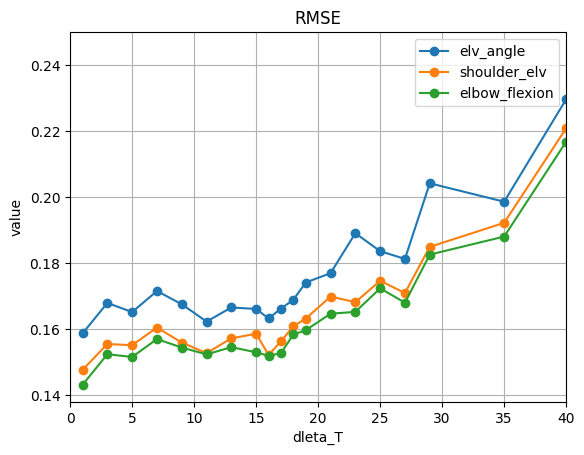

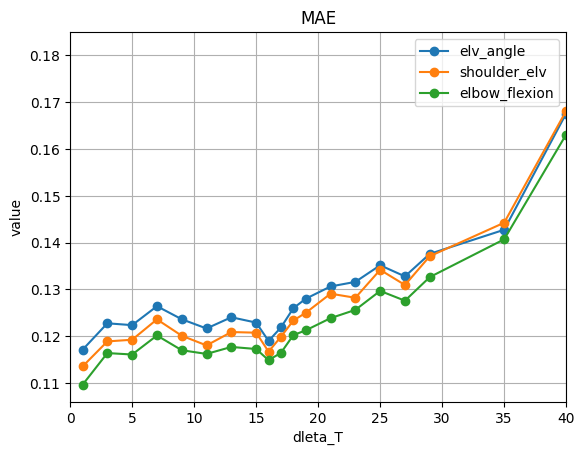

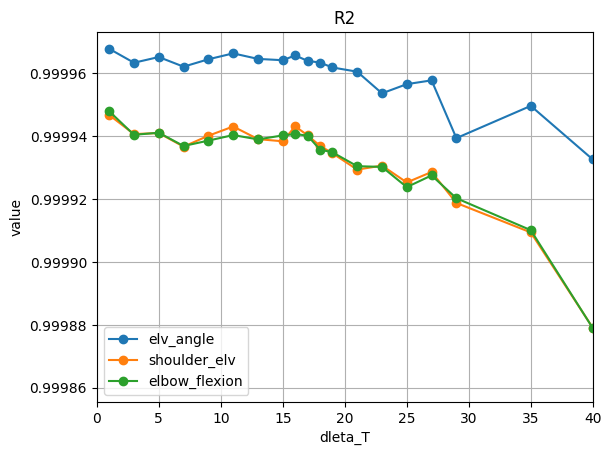

In [2]:
# 多个文件夹
from datetime import datetime
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from utils.tools import make_dir

from utils.tools import calMeans
    

delta_Tlist = []

# 自定义排序函数：提取倒数第二个数字
def sort_key(folder_name):
    # 假设文件夹名称格式为 MJ_PCA_1_256，提取倒数第二个数字
    parts = folder_name.split('_')  # 按下划线分割
    if len(parts) >= 2 and parts[-2].isdigit():  # 确保倒数第二个部分是数字
        delta_Tlist.append(int(parts[-2]))
        return int(parts[-2])  # 返回倒数第二个数字作为排序键
    else:
        return float('inf')  # 如果不符合格式，放在最后

formatted_time = datetime.now().strftime("%m-%d-%H:%M:%S")
saveFolderName = "4-16_Delta_T:1-300——指标对比"
save_Dir = os.path.join('/home/admin123/SATData/Run', "figures", formatted_time)
make_dir(save_Dir)

parent_folderL = ['/home/admin123/SATData/Run/Delta_T_evaluation']
sorted_subfolderL = []
for parent_folder in parent_folderL:
    subfolders = [name for name in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, name))]
# 对子文件夹进行排序
    sorted_subfolders = sorted(subfolders, key=sort_key)
    sorted_subfolderL.append(sorted_subfolders)


mean_rmseL = []
mean_maeL = []
mean_r2L = []
delta_Tlist = sorted(set(delta_Tlist))
print("delta_Tlist: ", delta_Tlist)

for i in range(len(sorted_subfolderL[0])):
    rmseL = []
    maeL = []
    r2L = []
    for j in range(len(sorted_subfolderL)):
        file_path = os.path.join(parent_folder, sorted_subfolderL[j][i], "metrics.json")
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)  # 将 JSON 数据加载为 Python 对象
            rmseL.append(np.array(data['rmse']))
            maeL.append(np.array(data['mae']))
            r2L.append(np.array(data['r2']))
    rmse = np.vstack(rmseL)
    mae = np.vstack(maeL)
    r2 = np.vstack(r2L)
    rmse_m, mae_m, r2_m = calMeans(rmse, mae, r2, allFlag=False)
    mean_rmseL.append(rmse_m)
    mean_maeL.append(mae_m)
    mean_r2L.append(r2_m)
    # print(rmse)


xleft = 0
xright = 40

mean_maeL = np.array(mean_maeL)
mean_rmseL = np.array(mean_rmseL)
mean_r2L = np.array(mean_r2L)
plt.figure()
png_path = os.path.join(save_Dir, "RMSE.png")
plt.plot(delta_Tlist, mean_rmseL[:,0], marker='o', linestyle='-', label='elv_angle')  # 线条和点
plt.plot(delta_Tlist, mean_rmseL[:,1], marker='o', linestyle='-', label='shoulder_elv')  # 线条和点
plt.plot(delta_Tlist, mean_rmseL[:,2], marker='o', linestyle='-', label='elbow_flexion')  # 线条和点
plt.xlabel("dleta_T")
plt.ylabel("value")
plt.grid()
plt.legend()
plt.title("RMSE")
plt.xlim(0, xright)
plt.savefig(png_path, dpi=300, bbox_inches='tight') 



plt.figure()
png_path = os.path.join(save_Dir, "MAE.png")
plt.plot(delta_Tlist, mean_maeL[:,0], marker='o', linestyle='-', label='elv_angle')  # 线条和点
plt.plot(delta_Tlist, mean_maeL[:,1], marker='o', linestyle='-', label='shoulder_elv')  # 线条和点
plt.plot(delta_Tlist, mean_maeL[:,2], marker='o', linestyle='-', label='elbow_flexion')  # 线条和点
plt.xlabel("dleta_T")
plt.ylabel("value")
plt.title("MAE")
plt.grid()
plt.legend()
plt.xlim(0, xright)
plt.savefig(png_path, dpi=300, bbox_inches='tight')


plt.figure()
png_path = os.path.join(save_Dir, "R2.png")
plt.plot(delta_Tlist, mean_r2L[:,0], marker='o', linestyle='-', label='elv_angle')  # 线条和点
plt.plot(delta_Tlist, mean_r2L[:,1], marker='o', linestyle='-', label='shoulder_elv')  # 线条和点
plt.plot(delta_Tlist, mean_r2L[:,2], marker='o', linestyle='-', label='elbow_flexion')  # 线条和点
plt.xlabel("dleta_T")
plt.ylabel("value")
plt.title("R2")
plt.grid()
plt.legend()
plt.xlim(0, xright)
plt.savefig(png_path, dpi=300, bbox_inches='tight')

排序后的子文件夹列表：


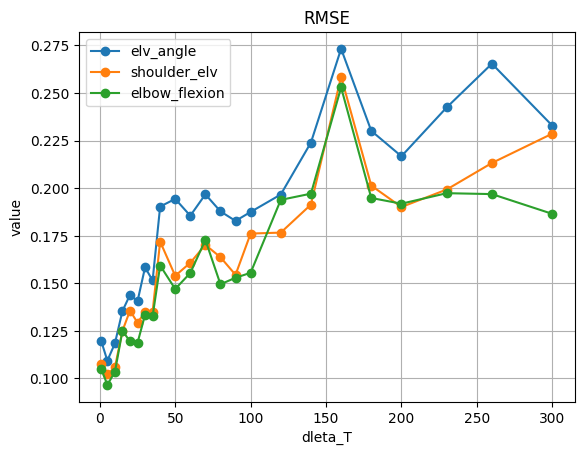

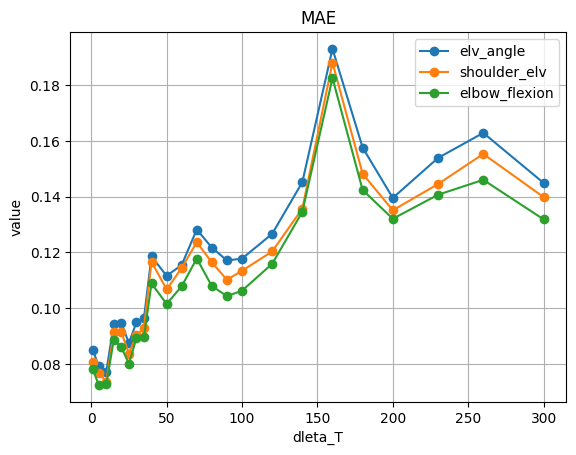

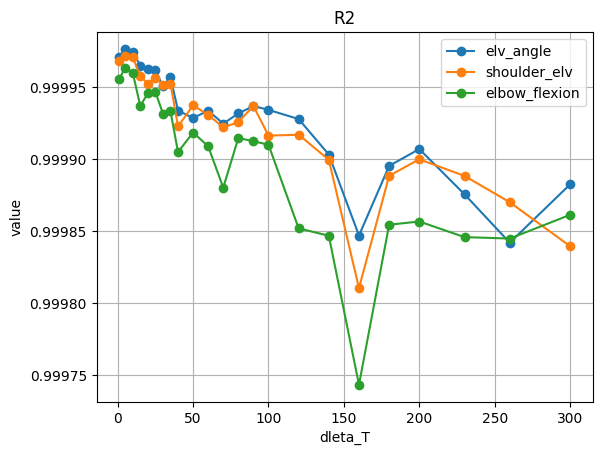

In [26]:
import json
import numpy as np
import os
import matplotlib.pyplot as plt

delta_Tlist = []
# 自定义排序函数：提取倒数第二个数字
def sort_key(folder_name):
    # 假设文件夹名称格式为 MJ_PCA_1_256，提取倒数第二个数字
    parts = folder_name.split('_')  # 按下划线分割
    if len(parts) >= 2 and parts[-2].isdigit():  # 确保倒数第二个部分是数字
        delta_Tlist.append(int(parts[-2]))
        return int(parts[-2])  # 返回倒数第二个数字作为排序键
    else:
        return float('inf')  # 如果不符合格式，放在最后


parent_folder = '/home/admin123/SATData/Run/SeEANet/04-15-10:59:08'  # 替换为你的父文件夹路径
subfolders = [name for name in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, name))]
# 对子文件夹进行排序
sorted_subfolders = sorted(subfolders, key=sort_key)

mean_rmseL = []
mean_maeL = []
mean_r2L = []
delta_Tlist = sorted(delta_Tlist)
# 打印排序后的子文件夹列表
print("排序后的子文件夹列表：")
for folder in sorted_subfolders:
    file_path = os.path.join(parent_folder, folder, "metrics.json")
    # 打开并读取 JSON 文件
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)  # 将 JSON 数据加载为 Python 对象

    rmse = np.array(data['rmse'])
    rmse_m = np.mean(rmse, axis=0)
    mean_rmseL.append(rmse_m)

    mae = np.array(data['mae'])
    mae_m = np.mean(mae,axis=0)
    mean_maeL.append(mae_m)

    r2 = np.array(data['r2'])
    r2_m = np.mean(r2,axis=0)
    mean_r2L.append(r2_m)


mean_maeL = np.array(mean_maeL)
mean_rmseL = np.array(mean_rmseL)
mean_r2L = np.array(mean_r2L)


plt.figure()
# png_path = os.path.join('/home/admin123/SATData/Run', formatted_time, "RMSE.png")
plt.plot(delta_Tlist, mean_rmseL[:,0], marker='o', linestyle='-', label='elv_angle')  # 线条和点
plt.plot(delta_Tlist, mean_rmseL[:,1], marker='o', linestyle='-', label='shoulder_elv')  # 线条和点
plt.plot(delta_Tlist, mean_rmseL[:,2], marker='o', linestyle='-', label='elbow_flexion')  # 线条和点
plt.xlabel("dleta_T")
plt.ylabel("value")
plt.grid()
plt.legend()
plt.title("RMSE")
# plt.savefig(png_path, dpi=300, bbox_inches='tight') 


plt.figure()
# png_path = os.path.join('/home/admin123/SATData/Run', formatted_time, "MAE.png")
plt.plot(delta_Tlist, mean_maeL[:,0], marker='o', linestyle='-', label='elv_angle')  # 线条和点
plt.plot(delta_Tlist, mean_maeL[:,1], marker='o', linestyle='-', label='shoulder_elv')  # 线条和点
plt.plot(delta_Tlist, mean_maeL[:,2], marker='o', linestyle='-', label='elbow_flexion')  # 线条和点
plt.xlabel("dleta_T")
plt.ylabel("value")
plt.title("MAE")
plt.grid()
plt.legend()
# plt.savefig(png_path, dpi=300, bbox_inches='tight')


plt.figure()
# png_path = os.path.join('/home/admin123/SATData/Run', formatted_time, "R2.png")
plt.plot(delta_Tlist, mean_r2L[:,0], marker='o', linestyle='-', label='elv_angle')  # 线条和点
plt.plot(delta_Tlist, mean_r2L[:,1], marker='o', linestyle='-', label='shoulder_elv')  # 线条和点
plt.plot(delta_Tlist, mean_r2L[:,2], marker='o', linestyle='-', label='elbow_flexion')  # 线条和点
plt.xlabel("dleta_T")
plt.ylabel("value")
plt.title("R2")
plt.grid()
plt.legend()
# plt.savefig(png_path, dpi=300, bbox_inches='tight')